In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import datetime

### Загрузка данных
Воспользуемся уже известным нам набором с велосипедами в Сиэтле

In [ ]:
temp=pd.read_csv('Fremont_Bridge_Bicycle_Counter.csv',index_col='Date',parse_dates=True)
display(temp.head(3))
display(temp.info())

Возмем направление проезда (для простоты) в одном направлении

In [ ]:
df_E=pd.DataFrame(temp['Fremont Bridge East Sidewalk'])
df_E.head(3)

### Календарь выходных США 
Необходимость использования требует доказательства как и выходные дни, для которых мы ранее преводили доказательство, но мы его пропустим

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2019', return_name=True)
holidays.head()

### Увеличиваем панель с данными
Добавляем данные о годе, квартале, месяце, дне недели, рабочем дне, выходном, дне месяца

In [ ]:
# Год
df_E['year'] = df_E.index.year
# Месяц
df_E['month'] = df_E.index.month
# Час
df_E['hour'] = df_E.index.hour

# Квартал
df_E['Quarter'] = df_E.index.quarter.astype('str')
# Номер месяца
df_E['NumOfMonth'] = df_E.index.month.astype('str')
# Номер недели
df_E['NumOfWeek'] = df_E.index.weekofyear
# День недели
df_E['DayOfWeek'] = df_E.index.dayofweek.astype('str')
# Выходной или нет
df_E['WorkdayOrNot'] = np.where(df_E.index.dayofweek<5, 'workday', 'weekend')
df_E.loc[df_E.index.strftime('%Y-%m-%d').isin(holidays.index.strftime('%Y-%m-%d')), 'WorkdayOrNot'] = 'weekend'
# День месяца
df_E['Day'] = df_E.index.day
# День года
df_E['DayOfYear'] = df_E.index.dayofyear
df_E.head(5)

# может еще, что добавите?

In [ ]:
df_E=df_E.fillna(0)
df_E.head(5)

In [7]:
# выделили вектор целевых переменных 
Y=df_E['Fremont Bridge East Sidewalk']

In [ ]:
# выделили панель с данными 
df_X=df_E.drop('Fremont Bridge East Sidewalk', axis=1)
display(df_X.head(5))

In [ ]:
# построили дамми на кварталах, месяцах, днях недели, выходных 
df_dammy=pd.concat(
    [
    df_X[['year','month','hour']],
    pd.get_dummies(df_X[['Quarter', 'NumOfMonth', 'DayOfWeek', 'WorkdayOrNot']])
    ],
    axis=1)
df_dammy.head(5)

### Домашнее задание

Цель найти лучшую модель для прогноза на конкретный день (модель 1) и на конкретный час (модель 2) 
Кстати, может достаточно сделать модель 2 а день агрегировать на часовой модели?
Валидировать модель.
Данные можно использовать до 31 декабря 2018, для обучения и валидации модели.
Горизонт предсказания 3 месяца!!!
Год 2019, только для тестирования результата, и определения итогового score.

Построить итоговую предсказательную модель (вводится дата любоя дата/время с 1 января 2019 года + 3 мес.)
Модель 1 - ввел дату и время получил количество велосипедов в день 
Модель 2 - ввел дату и время получил количество велосипедов в час

Можно сделать одну модель, которая в зависимости от полноты ввода даных даст ответ. 

#### Внимание!
Отюда и ниже самый простой пример по прогнозированию. Вам предстоит сделать лучше. Здесь указаны общие подходы. Все сделано на коленке и является крайне сомнительным прототипом :)

In [10]:
from sklearn.metrics import r2_score

# отрезан хвост для валидации (которую я тут не делаю)
X=df_dammy.values
y=Y.values
pr=365*24
X_train=X[:-pr]
y_train=y[:-pr]
X_test=X[-pr:]
y_test=y[-pr:]

In [11]:
X_train.shape

(56928, 28)

In [12]:
# простенькая моделька и на коленке score БЕЗ ВАЛИДАЦИИ TimeSeriesSplit, а она нужна !!!
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=300)
model.fit(X_train, y_train)
r2_score(model.predict(X_test), y_test)

0.7744652733760319

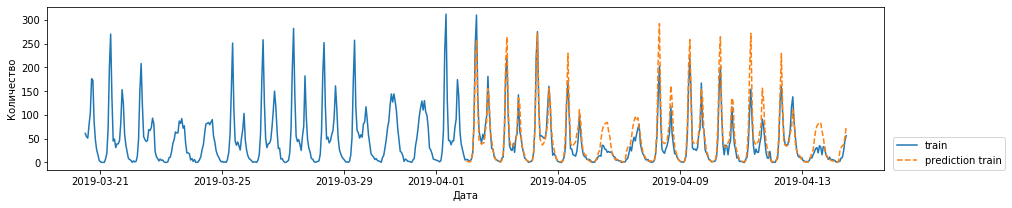

In [26]:
# Простенькая картинка по типу "попал - не попал"
Delta=300
plt.figure(figsize=(15, 3))
plt.plot(
    df_E.index.values[(-pr-Delta):(-pr+Delta)], 
    y[(-pr-Delta):(-pr+Delta)], label="train")
plt.plot(
    df_E.index.values[-pr:(-pr+Delta)], 
    model.predict(X[-pr:(-pr+Delta)]), 
    '--', label="prediction train")
plt.legend(loc=(1.01, 0))
plt.xlabel("Дата");
plt.ylabel("Количество");

# Д/з

# Модель на конкретный час

In [133]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
import xgboost as xgb

In [211]:
X_train = df_dammy.loc[:'2018-12-31']
y_train = Y.loc[:'2018-12-31']

y_test = Y.loc['2018-12-31':'2019-04-1']
X_test = df_dammy.loc['2018-12-31':'2019-04-1']

model = RandomForestRegressor(n_jobs = -1,criterion='r2')

# XGB

In [113]:
model = xgb.XGBRegressor(objective='reg:squarederror')
param_search = {'max_depth' : [3, 5],
               'n_estimators':[100,300,500]}

tss = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tss, param_grid=param_search,scoring='r2')
gsearch.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [3, 5], 'n_estimators': [100

In [114]:
r2_score(y_test,gsearch.predict(X_test))

0.6564827193117617

# Linear regressions

In [115]:
ridge_regr = RidgeCV(cv=tss)
ridge_regr.fit(X_train,y_train)
r2_score(y_test,ridge_regr.predict(X_test))

0.009579087363890237

In [116]:
lasso_regr = LassoCV(cv=tss)
lasso_regr.fit(X_train,y_train)
r2_score(y_test,ridge_regr.predict(X_test))

0.009579087363890237

In [118]:
ridge_regr = ElasticNetCV(cv=tss)
ridge_regr.fit(X_train,y_train)
r2_score(y_test,ridge_regr.predict(X_test))

0.012494696795167237

In [23]:
int(X.shape[1]/3)

9

бесполезны здесь

# Случайный лес (наилучшая модель)

In [212]:
rf = RandomForestRegressor(n_jobs=-1,max_features=int(X.shape[1]/3))
param_search = {'max_depth' : [14],
                'n_estimators':[1000],
               }

tss = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=rf, cv=tss, param_grid=param_search,scoring='r2')
gsearch.fit(X_train,y_train)
r2_score(y_test,gsearch.predict(X_test))

0.6937222624889023

In [216]:
predicts = gsearch.predict(X_test)

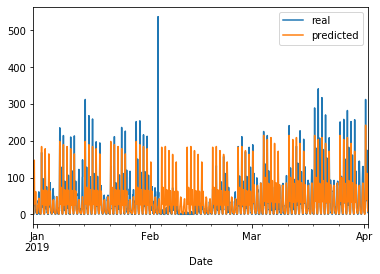

In [217]:
data_hour = {'real':y_test,'predicted':predicts}
pd.DataFrame(data_hour).plot();

# Теперь для дней

In [164]:
X_train = df_dammy[:'2018-12-31'].resample('1d').first()
X_train.drop('hour',inplace=True,axis=1)
y_train = Y[:'2018-12-31'].resample('1d').sum()

y_test = Y['2018-12-31':'2019-04-1'].resample('1d').sum()
y_test = y_test[1:]
X_test = df_dammy['2018-12-31':'2019-04-1'].resample('1d').first()
X_test = X_test.iloc[1:,:]
X_test.drop('hour',inplace=True,axis=1)

In [165]:
rf = RandomForestRegressor(n_jobs=-1,max_features=int(X.shape[1]/3))
param_search = {'max_depth' : np.arange(2,12,1),
                'n_estimators':[200],
               }

tss = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=rf, cv=tss, param_grid=param_search,scoring='r2')
gsearch.fit(X_train,y_train)
r2_score(y_test,gsearch.predict(X_test))

0.24509914322342263

In [166]:
gsearch.best_params_

{'max_depth': 7, 'n_estimators': 200}

In [188]:
pd.Series(y_test)

Date
2019-01-01     335.0
2019-01-02     895.0
2019-01-03     649.0
2019-01-04     809.0
2019-01-05     482.0
               ...  
2019-03-28    1455.0
2019-03-29    1420.0
2019-03-30    1239.0
2019-03-31    1134.0
2019-04-01    1629.0
Freq: D, Name: Fremont Bridge East Sidewalk, Length: 91, dtype: float64

In [195]:
data_day = {'predicted':gsearch.predict(X_test), 'real':y_test}

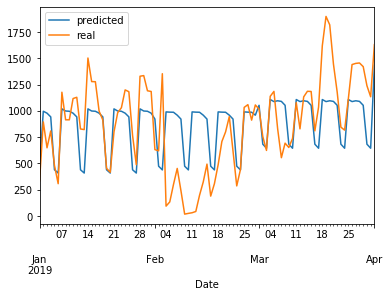

In [196]:
pd.DataFrame(data_day,index=y_test.index).plot();

In [129]:
model = xgb.XGBRegressor(objective='reg:squarederror')
param_search = {'max_depth' : np.arange(1,10,1),
               'n_estimators':np.arange(20,200,10)}

tss = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tss, param_grid=param_search,scoring='r2')
gsearch.fit(X_train,y_train)
r2_score(y_test,gsearch.predict(X_test))

0.19333092842485733

### Итог: лучше предсказывать для часов, а затем аггрегировать т.к. так больше информации и предсказание точнее

In [218]:
predicts = pd.DataFrame(predicts,index=y_test.index,columns=["bikes_passed"])

# Предсказание для дней

In [219]:
predicts.loc['2019-03-01'].sum()

bikes_passed    992.312022
dtype: float64

# Предсказание для часа

In [220]:
predicts.loc['2019-03-01 01:00:00']

bikes_passed    1.466778
Name: 2019-03-01 01:00:00, dtype: float64

In [221]:
predicts

,bikes_passed
Date,
2018-12-31 00:00:00,0.806838
2018-12-31 01:00:00,0.658191
2018-12-31 02:00:00,0.803658
2018-12-31 03:00:00,0.780618
2018-12-31 04:00:00,2.638440
...,...
2019-04-01 19:00:00,69.372002
2019-04-01 20:00:00,30.756951
2019-04-01 21:00:00,18.156155


In [225]:
predicts.to_csv('bikes.csv')